In [26]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression

from cryptic_rnn import *

In [169]:
def tuple_output(step_tuple, cue_dic):
    out = cue_dic[step_tuple[1]]
    if step_tuple[0] == '-':
        out = out*-1
    return out

def plot_RDM_regression(dms, dms_p, ft_cue_dicts, valset, allseqs, ranked = False, title = ''):
    step_rs = []
    step_rs_p = []
    step_num = []
    for s in range(4): 
        rs = regress_RDM(s, dms, ft_cue_dicts, valset, allseqs, ranked)
        rs_p = regress_RDM(s, dms_p, ft_cue_dicts, valset, allseqs, ranked)
        step_rs.append(rs)
        step_rs_p.append(rs_p)
        step_num.append([s+1]*len(rs))


    r_sq = [item for sublist in step_rs for item in sublist]
    r_sq_p = [item for sublist in step_rs_p for item in sublist]
    steps = [item for sublist in step_num for item in sublist]

    all_r_sq = r_sq + r_sq_p
    all_steps = steps + steps
    training = ['no primitives']*len(r_sq) + ['with primitives']*len(r_sq_p)

    r_sq_scores = pd.DataFrame({'R_squared': all_r_sq, 'Step': all_steps, 'Training': training})
    x_data = np.append((np.array(steps) - 0.2), (np.array(steps) + 0.2))
    x_jittered = np.array(x_data) + np.random.normal(0,0.05,len(x_data))
    x_jittered = x_jittered - 1
    colors = ['blue']*len(r_sq) + ['orange']*len(r_sq_p)    

    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='without primitives'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='with primitives')] 

    fig, ax = plt.subplots(figsize= (8,5))
    violins = sns.violinplot(data=r_sq_scores, x="Step", y="R_squared", hue="Training",\
                             palette = ['white', 'white'])

    for x, y, color in zip(x_jittered, r_sq_scores["R_squared"], colors):
        ax.scatter(x, y, s = 20, color=color, alpha=0.2)

    plt.legend(handles=legend_elements)
    plt.title('Regression between model RDM and ground truth' + title)


In [3]:
# read data

save_dir = '../results/addition_trigrams_3inputs_bp'

with open(save_dir, 'rb') as f:
    res1 = pickle.load(f)

In [4]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1200
num_sims = 104

In [16]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print('cue_dict ',cue_dict)
primitives = generate_pos_primitives(all_syms, cue_dict)
print('primitives ',primitives)

trainseqs = generate_pos_other(ops, all_syms[:-1], cue_dict)
trainseqs_b = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_balanced_primitives(ops, all_syms, cue_dict)
trainseqs_p = trainseqs + primitives
trainseqs_bp = trainseqs_b + primitives

print('trainseqs ',trainseqs)
print('trainseqs_b ',trainseqs_b)
print('trainseqs_p ',trainseqs_p)
print('trainseqs_bp ',trainseqs_bp)

testseqs_all = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in testseqs_all if seq not in trainseqs_b]

print('testseqs ', testseqs )
val_idx = [idx for idx, seq in enumerate(testseqs_all) if seq not in trainseqs_b]


cue_dict  {'A': 4, 'B': 2, 'C': 17, 'D': 14}
primitives  [[('+', 'A'), '=', 4], [('+', 'B'), '=', 2], [('+', 'C'), '=', 17], [('+', 'D'), '=', 14]]
trainseqs  [[('+', 'A'), ('+', 'B'), '=', 6], [('+', 'B'), ('+', 'C'), '=', 19], [('+', 'C'), ('+', 'A'), '=', 21]]
trainseqs_b  [[('+', 'A'), ('+', 'B'), '=', 6], [('+', 'B'), ('+', 'C'), '=', 19], [('+', 'C'), ('+', 'A'), '=', 21], ['A', ('+', 'C'), '=', 21], ['B', ('+', 'D'), '=', 16]]
trainseqs_p  [[('+', 'A'), ('+', 'B'), '=', 6], [('+', 'B'), ('+', 'C'), '=', 19], [('+', 'C'), ('+', 'A'), '=', 21], [('+', 'A'), '=', 4], [('+', 'B'), '=', 2], [('+', 'C'), '=', 17], [('+', 'D'), '=', 14]]
trainseqs_bp  [[('+', 'A'), ('+', 'B'), '=', 6], [('+', 'B'), ('+', 'C'), '=', 19], [('+', 'C'), ('+', 'A'), '=', 21], ['A', ('+', 'C'), '=', 21], ['B', ('+', 'D'), '=', 16], [('+', 'A'), '=', 4], [('+', 'B'), '=', 2], [('+', 'C'), '=', 17], [('+', 'D'), '=', 14]]
testseqs  [[('+', 'A'), ('+', 'A'), '=', 8], [('+', 'A'), ('+', 'C'), '=', 21], [('+', 'A

no. 100% trained RNNs:  600


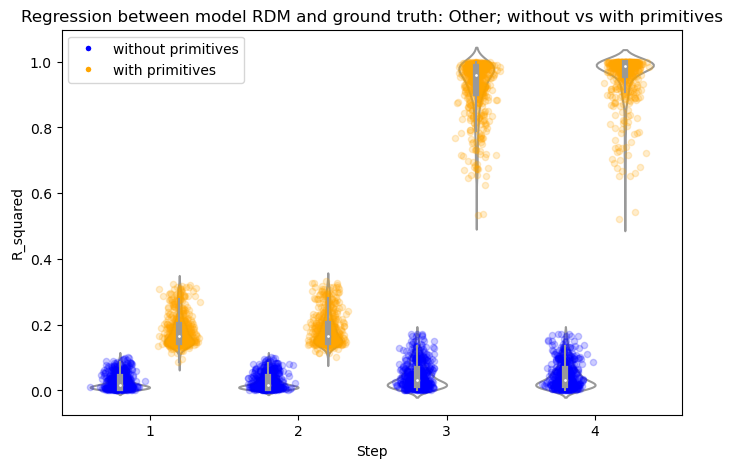

In [35]:
full_rdmats = calculate_RDMs(res1, testseqs_all)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
dms_b = full_rdmats['rdms_b']
dms_bp = full_rdmats['rdms_bp']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

plot_RDM_regression(dms, dms_p, ft_cue_dicts, val_idx, testseqs_all, title = ': Other; without vs with primitives')

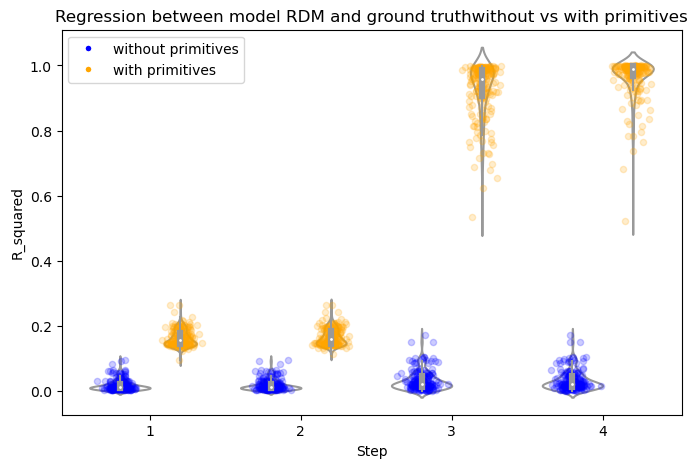

In [31]:
plot_RDM_regression(dms, dms_p, ft_cue_dicts, val_idx, testseqs_all, title = 'without vs with primitives')

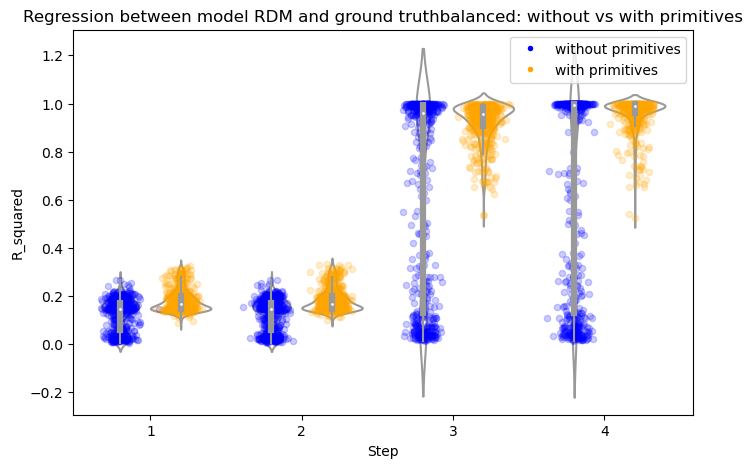

In [36]:
plot_RDM_regression(dms_b, dms_bp, ft_cue_dicts, val_idx, testseqs_all, title = 'balanced: without vs with primitives')

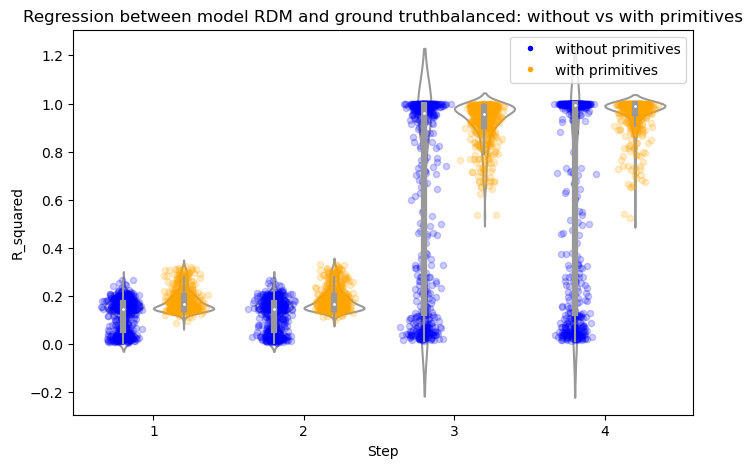

In [37]:
plot_RDM_regression(dms_b, dms_p, ft_cue_dicts, val_idx, testseqs_all, title = 'balanced: without vs with primitives')

In [86]:
 tuple_output(outs_trials[0][0], cue_dict)

5

In [82]:
calculate_output([outs_trials[0][0]], cue_dict)

IndexError: list index out of range

In [ ]:
step_tuple[0]

In [76]:
outs_trials = change_dict(all_seqs, cue_dict)

In [95]:
outs_2d = []
for tr in outs_trials:
    outs_2d.append([tuple_output(tr[0], cue_dict), tuple_output(tr[1], cue_dict)])
RDM_truth_2d = euclidean_distances(outs_2d)

In [92]:
outs_2d

[[5, 5],
 [5, 6],
 [5, 10],
 [5, 14],
 [6, 5],
 [6, 6],
 [6, 10],
 [6, 14],
 [10, 5],
 [10, 6],
 [10, 10],
 [10, 14],
 [14, 5],
 [14, 6],
 [14, 10],
 [14, 14]]

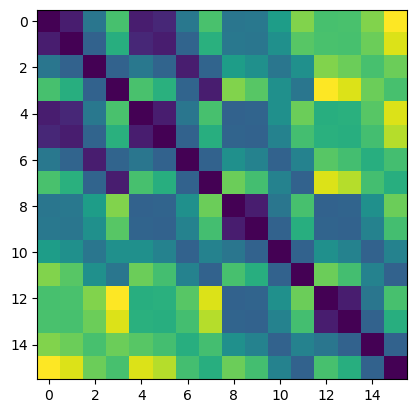

In [94]:
plt.imshow(euclidean_distances(outs_2d))

In [ ]:
rs = []
for i, cuedict in enumerate(ft_cue_dicts):
    if ranked:
        curr_tests = change_dict(all_seqs, rank_dict)
    else:
        curr_tests = change_dict(all_seqs, cuedict)
    control_outs = [t[-1] for t in curr_tests]
    control_RDM = abs(np.array([control_outs]*16) - np.array([control_outs]*16).T)
    x = []
    y = []
    for p in valset_idx:
        for q in valset_idx:
            x.append(rdm[time_step][i][p,q])
            y.append(control_RDM[p,q])
    x = np.array(x).reshape(-1,1)
    y = np.array(y)
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    rs.append(r_sq)

In [139]:
outs_ranked = change_dict(all_seqs, rank_dict)
outs_ranked = [t[-1] for t in outs_ranked]
ranked_RDM = abs(np.array([outs_ranked]*16) - np.array([outs_ranked]*16).T)
ranked_RDM[0][:10]

array([0., 1., 2., 3., 1., 2., 3., 4., 2., 3.])

In [237]:
i = 88
cuedict = ft_cue_dicts[i]
all_seqs = testseqs_all
valset_idx = val_idx
rank_dict = {'A':-1.5, 'B':-0.5, 'C':0.5, 'D':1.5}
rdm = dms[time_step][i]
time_step = 3
controls = ['1D ground truth', '1D rank','2D ground truth', '2D rank']
def best_control(rdm, valset_idx, all_seqs, cuedict, rank_dict):
    
    controls = ['1D ground truth', '1D rank','2D ground truth', '2D rank']
    
    outs_ranked = change_dict(all_seqs, rank_dict)
    outs_ranked = [t[-1] for t in outs_ranked]
    ranked_RDM = abs(np.array([outs_ranked]*16) - np.array([outs_ranked]*16).T)

    outs_truth = change_dict(all_seqs, cuedict)
    outs_truth = [t[-1] for t in outs_truth]
    truth_RDM = abs(np.array([outs_truth]*16) - np.array([outs_truth]*16).T)

    outs_2d = []
    for tr in outs_trials:
        outs_2d.append([tuple_output(tr[0], cue_dict), tuple_output(tr[1], cue_dict)])
    truth_2d_RDM = euclidean_distances(outs_2d)

    outs_2d = []
    for tr in outs_trials:
        outs_2d.append([tuple_output(tr[0], rank_dict), tuple_output(tr[1], rank_dict)])
    ranked_2d_RDM = euclidean_distances(outs_2d)

    y = []
    x_truth = []
    x_ranked = []
    x_truth_2d = []
    x_ranked_2d = []
    for p in valset_idx:
        for q in valset_idx:
            y.append(rdm[p,q])
            x_truth.append(truth_RDM[p,q])
            x_ranked.append(ranked_RDM[p,q])
            x_truth_2d.append(truth_2d_RDM[p,q])
            x_ranked_2d.append(ranked_2d_RDM[p,q])
    y = np.array(y)#.reshape(-1,1)
    x = pd.DataFrame({'ground_truth': np.array(y_truth), 'ranked_control':np.array(y_ranked),
                      'ground_truth_2d': np.array(y_truth_2d), 'ranked_control_2d':np.array(y_ranked_2d)})
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    importance = model.coef_
    return controls[np.argmax(importance)]

In [230]:
len(dms_p[0])

600

(array([423.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 177.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

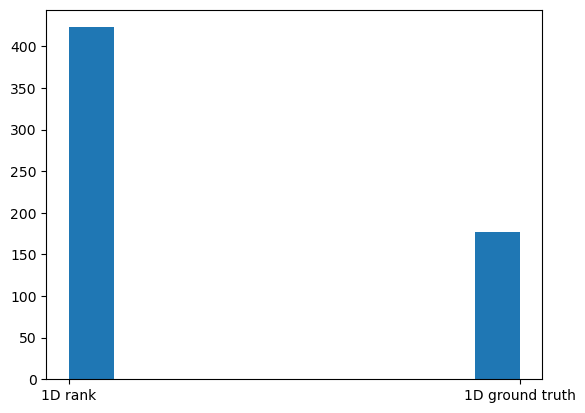

In [247]:
cuedict = ft_cue_dicts[i]
all_seqs = testseqs_all
valset_idx = val_idx
rank_dict = {'A':-1.5, 'B':-0.5, 'C':0.5, 'D':1.5}

time_step = 2
mats = dms_p[time_step]

winning_control = []
for i, rdm in enumerate(mats):
    cuedict = ft_cue_dicts[i]
    winning_control.append(best_control(rdm, valset_idx, all_seqs, cuedict, rank_dict))

plt.hist(winning_control)

In [243]:
np.argmax([1,2,3,3,4,55,55,55])

5

(array([561.,   0.,   0.,   0.,   0.,  28.,   0.,   0.,   0.,  11.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

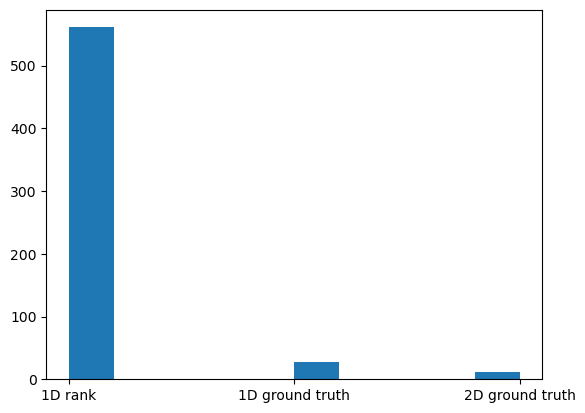

In [248]:
cuedict = ft_cue_dicts[i]
all_seqs = testseqs_all
valset_idx = val_idx
rank_dict = {'A':-1.5, 'B':-0.5, 'C':0.5, 'D':1.5}

time_step = 2
mats = dms[time_step]

winning_control = []
for rdm in mats:
    winning_control.append(best_control(rdm, valset_idx, all_seqs, cuedict, rank_dict))

plt.hist(winning_control)

(array([336.,   0.,   0.,   0.,   0., 257.,   0.,   0.,   0.,   7.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

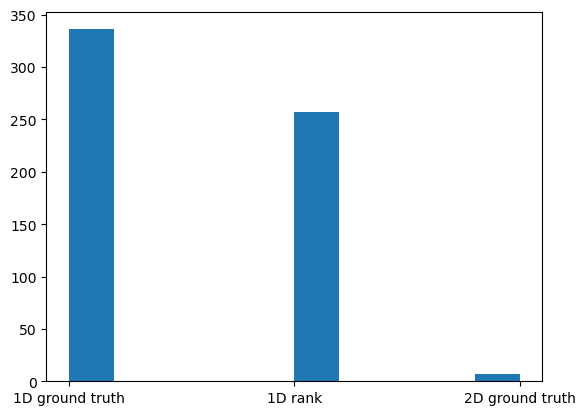

In [249]:
cuedict = ft_cue_dicts[i]
all_seqs = testseqs_all
valset_idx = val_idx
rank_dict = {'A':-1.5, 'B':-0.5, 'C':0.5, 'D':1.5}

time_step = 2
mats = dms_b[time_step]

winning_control = []
for rdm in mats:
    winning_control.append(best_control(rdm, valset_idx, all_seqs, cuedict, rank_dict))

plt.hist(winning_control)

(array([423.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 177.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

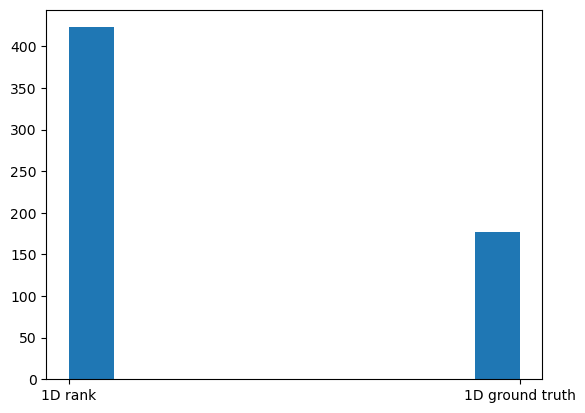

In [250]:
cuedict = ft_cue_dicts[i]
all_seqs = testseqs_all
valset_idx = val_idx
rank_dict = {'A':-1.5, 'B':-0.5, 'C':0.5, 'D':1.5}

time_step = 2
mats = dms_bp[time_step]

winning_control = []
for rdm in mats:
    winning_control.append(best_control(rdm, valset_idx, all_seqs, cuedict, rank_dict))

plt.hist(winning_control)

In [122]:
import statsmodels.api as sm 


In [123]:
X = pd.DataFrame({'ground_truth': np.array(y_truth), 'ranked_control':np.array(y_ranked),
                  'ground_truth_2d': np.array(y_truth_2d), 'ranked_control_2d':np.array(y_ranked_2d)})
y = np.array(x).reshape(-1,1)

In [124]:
X = sm.add_constant(X) 
est = sm.OLS(y, X).fit() 
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     4.010
Date:                Fri, 10 Mar 2023   Prob (F-statistic):            0.00870
Time:                        14:17:26   Log-Likelihood:                -390.35
No. Observations:                 169   AIC:                             788.7
Df Residuals:                     165   BIC:                             801.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.3167      0.419      5.528      0.000       1.489       3.144
ground_truth         -0.3043      0.175     -1.734      0.085      -0.651       0.042
ranked_control        0.8839      0.445      1.984      0.049       0.004       1.763
ground_truth_2d       0.0900      0.042      2.122      0.035       0.006       0.174
ranked_control_2d     0.0900      0.042      2.122      0.035       0.006       0.174
==============================================================================
Omnibus:                       14.896   Durbin-Watson:                   0.899
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               12.895
Skew:                           0.594   Prob(JB):                      0.00158
Kurtosis:                       2.351   Cond. No.                     3.98e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [103]:
model = LinearRegression().fit(x, y_truth)
r_sq = model.score(x, y_truth)
print('rsq: ', r_sq)
model.coef_

rsq:  0.9814127752915028


array([1.41832722])

In [104]:
model = LinearRegression().fit(x, y_ranked)
r_sq = model.score(x, y_ranked)
print('rsq: ', r_sq)
model.coef_

rsq:  0.9898841279747863


array([0.42256164])

In [105]:
def calculate_RDMs(res1, testseq, subset = 'all'):
    
    acc_df = res1['acc_df']
    if subset == 'ft':
        all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_b'] == 1)&\
                              (acc_df['acc_train_bp'] == 1) & (acc_df['acc_train_p'] == 1)].index
    elif subset == 'all':
        all_acc_mods = acc_df.index
    print('no. 100% trained RNNs: ', len(all_acc_mods))
    mod_list = all_acc_mods # choose subset of rnns 

    rdms = [[] for _ in range(4)] # initialise empty lists/arrays
    rdms_p = [[] for _ in range(4)]
    rdms_b = [[] for _ in range(4)] # initialise empty lists/arrays
    rdms_bp = [[] for _ in range(4)]
    # extracts res1ults from dictionary
    mods = res1['mods']
    mods_p = res1['mods_p']
    mods_b = res1['mods_b']
    mods_bp = res1['mods_bp']

    cue_dicts = res1['cue_dicts']
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 

        testseqs = change_dict(testseq, cue_dicts[m])
        test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
        testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=False)

        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(4): 
            hid_vals = np.array([hid[h+1,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)

        # get activations for primitive trained model
        hiddens_p, trials = get_reps(mods_p[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h+1,:] for hid in hiddens_p])
            rep_mat = euclidean_distances(hid_vals)
            rdms_p[h].append(rep_mat)

        # get activations for control model
        hiddens_b, trials = get_reps(mods_b[m], [testset], hidden_size)
        for h in range(4): 
            hid_vals = np.array([hid[h+1,:] for hid in hiddens_b]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms_b[h].append(rep_mat)

        # get activations for primitive trained model
        hiddens_bp, trials = get_reps(mods_p[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h+1,:] for hid in hiddens_bp])
            rep_mat = euclidean_distances(hid_vals)
            rdms_bp[h].append(rep_mat)

            
    return {'rdms': rdms, 'rdms_p': rdms_p, 'rdms_b': rdms_b, 'rdms_bp': rdms_bp, 'ft_cue_dicts': ft_cue_dicts}


########### regression

def regress_RDM(time_step, rdm, ft_cue_dicts, valset_idx, all_seqs, ranked = False, rank_dict=None):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(all_seqs, rank_dict)
        else:
            curr_tests = change_dict(all_seqs, cuedict)
        control_outs = [t[-1] for t in curr_tests]
        control_RDM = abs(np.array([control_outs]*16) - np.array([control_outs]*16).T)
        x = []
        y = []
        for p in valset_idx:
            for q in valset_idx:
                x.append(rdm[time_step][i][p,q])
                y.append(control_RDM[p,q])
        x = np.array(x).reshape(-1,1)
        y = np.array(y)
        model = LinearRegression().fit(x, y)
        r_sq = model.score(x, y)
        rs.append(r_sq)
    return rs

